In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import random as rn

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.tree import plot_tree

np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [149]:
aids = pd.read_csv('data/AIDS_Classification.csv')

In [150]:
aids.drop(columns={'z30', 'treat','str2', 'cd420','cd820'}, inplace=True)

In [151]:
class DataFrameTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformer, original_columns):
        self.transformer = transformer
        self.original_columns = original_columns
    
    def fit(self, X, y=None):
        self.transformer.fit(X, y)
        return self
    
    def transform(self, X, y=None):
        X_transformed = self.transformer.transform(X)
        if not isinstance(X_transformed, pd.DataFrame):
            X_transformed = pd.DataFrame(X_transformed, columns=self.get_feature_names_out())
        
        original_data = X[self.original_columns]
        
        X_final = pd.concat([original_data.reset_index(drop=True), X_transformed.reset_index(drop=True)], axis=1)
        return X_final
    
    def get_feature_names_out(self):
        return self.transformer.get_feature_names_out()

In [152]:
cols_to_scale = ['time', 'age', 'wtkg', 'karnof', 'preanti', 'cd40', 'cd80']
cols_to_one_hot = ['trt', 'strat']
orginal_columns = [col for col in aids.columns if col not in (cols_to_scale + cols_to_one_hot)]

preprocessor = ColumnTransformer(transformers = [
    ('numerical', MinMaxScaler(), cols_to_scale), # StandardScaler()
    ('one_hot', OneHotEncoder(drop='first'), cols_to_one_hot)
])

pipe = Pipeline(steps = [
                ('preprocessor', DataFrameTransformer(preprocessor, orginal_columns)),
])

# joblib.dump(pipe, 'models/data_transformer.pkl')

aids_t = pipe.fit_transform(aids)

aids_t.to_csv('data/aids_t.csv')

In [153]:
def metrics(model, X_train, y_train, X_test, y_test):
    # Przewidywanie wartości na zbiorze treningowym
    print('Metryki dla zbioru treningowego')
    print('-' * 50)

    y_pred = model.predict(X_train)

    # Obliczanie metryk
    accuracy = accuracy_score(y_train, y_pred)
    conf_matrix = confusion_matrix(y_train, y_pred)
    class_report = classification_report(y_train, y_pred)

    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", class_report)

    print('Metryki dla zbioru testowego')
    print('-' * 50)

    # Przewidywanie wartości na zbiorze testowym
    y_pred = model.predict(X_test)

    # Obliczanie metryk
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, digits =4)

    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", class_report)

In [154]:
X = aids_t.drop(columns=['infected'])
y = aids_t['infected']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Tworzenie modelu lasu losowego
clf1 = RandomForestClassifier(n_estimators=100, random_state=42)

# Trenowanie modelu
clf1.fit(X_train, y_train)

# Dokonanie predykcji na zbiorze testowym
y_pred = clf1.predict(X_test)

metrics(clf1, X_train, y_train, X_test, y_test)

Metryki dla zbioru treningowego
--------------------------------------------------
Accuracy: 1.0
Confusion Matrix:
 [[1213    0]
 [   0  391]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1213
           1       1.00      1.00      1.00       391

    accuracy                           1.00      1604
   macro avg       1.00      1.00      1.00      1604
weighted avg       1.00      1.00      1.00      1604

Metryki dla zbioru testowego
--------------------------------------------------
Accuracy: 0.8654205607476636
Confusion Matrix:
 [[383  22]
 [ 50  80]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8845    0.9457    0.9141       405
           1     0.7843    0.6154    0.6897       130

    accuracy                         0.8654       535
   macro avg     0.8344    0.7805    0.8019       535
weighted avg     0.8602    0.8654    0.8595       535



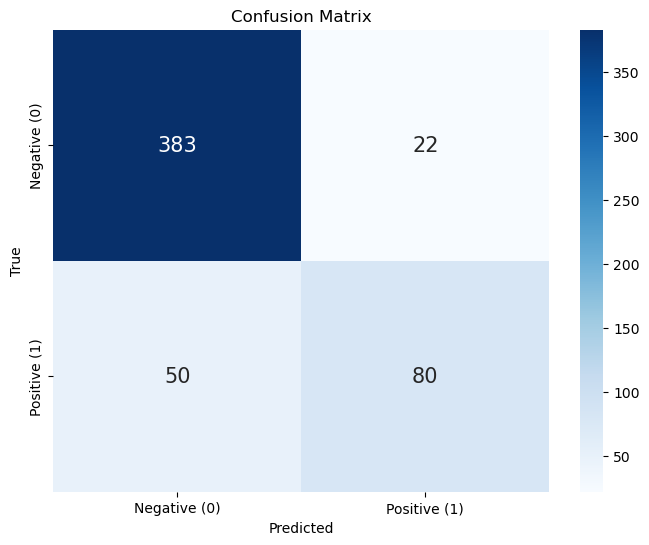

In [167]:
y_pred = clf1.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Definicja etykiet klas
class_labels = ['Negative (0)', 'Positive (1)']

# Wyświetlenie macierzy pomyłek z opisami
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, annot_kws={"fontsize":15})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

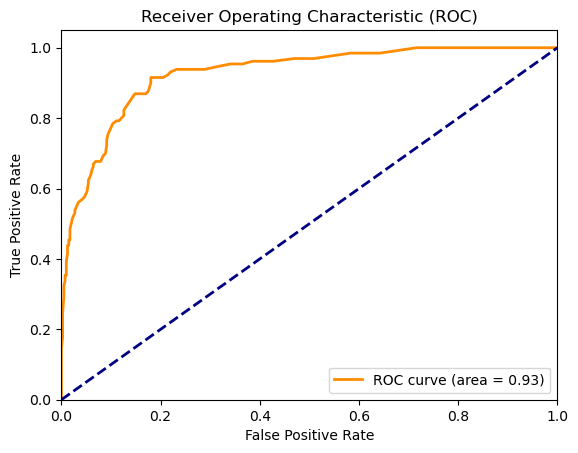

In [156]:
y_pred_prob = clf1.predict_proba(X_test)[:,1]


fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

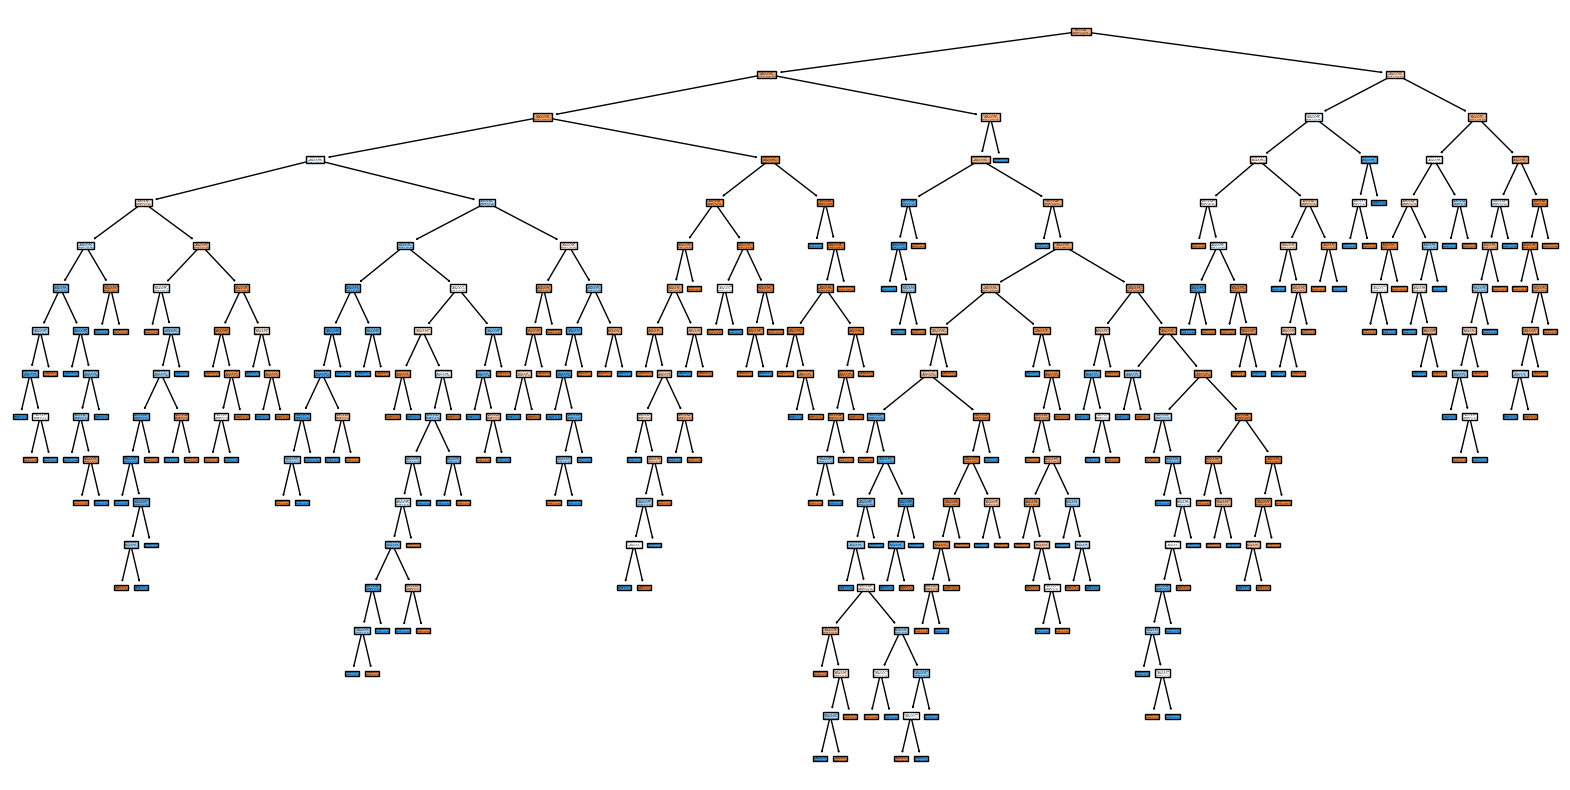

In [157]:
tree = clf1.estimators_[0]

# Wizualizacja drzewa
plt.figure(figsize=(20,10))
plot_tree(tree, filled=True)
plt.show()

In [158]:
# Tworzenie modelu lasu losowego
clf2 = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, min_samples_leaf=5, random_state=42)

# Trenowanie modelu
clf2.fit(X_train, y_train)

# Dokonanie predykcji na zbiorze testowym
y_pred = clf2.predict(X_test)

metrics(clf2, X_train, y_train, X_test, y_test)

Metryki dla zbioru treningowego
--------------------------------------------------
Accuracy: 0.9395261845386533
Confusion Matrix:
 [[1186   27]
 [  70  321]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      1213
           1       0.92      0.82      0.87       391

    accuracy                           0.94      1604
   macro avg       0.93      0.90      0.91      1604
weighted avg       0.94      0.94      0.94      1604

Metryki dla zbioru testowego
--------------------------------------------------
Accuracy: 0.8654205607476636
Confusion Matrix:
 [[385  20]
 [ 52  78]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8810    0.9506    0.9145       405
           1     0.7959    0.6000    0.6842       130

    accuracy                         0.8654       535
   macro avg     0.8385    0.7753    0.7993       535
weighted avg     0.8603    0.8654    0.8585 

In [159]:
# from sklearn.metrics import roc_auc_score
# from sklearn.feature_selection import chi2
# from scipy.stats import entropy

# y_probs = clf2.predict_proba(X_test)
# auc = roc_auc_score(y_test == 0, y_probs[:, 0])

# gini = 2 * auc - 1
# print(f'Wskaźnik Giniego: {gini:.4f}')

# # Obliczanie statystyki chi-kwadrat dla cech
# chi2_stats, p_values = chi2(X_train, y_train)
# for i, (chi2_stat, p_value) in enumerate(zip(chi2_stats, p_values)):
#     print(f'Cecha {i}: statystyka chi-kwadrat = {chi2_stat:.4f}, p-value = {p_value:.4f}')

# # Obliczanie entropii dla węzłów drzewa
# # Przykład dla pierwszego drzewa w lesie
# def compute_entropy(y):
#     class_counts = np.bincount(y)
#     probabilities = class_counts / len(y)
#     return entropy(probabilities, base=2)

# tree = clf2.estimators_[0]  # Pierwsze drzewo w RandomForest
# node_indices = tree.apply(X_train)  # Indeksy węzłów dla każdego przykładu

# # Obliczanie entropii dla każdego węzła
# unique_nodes = np.unique(node_indices)
# entropies = {node: compute_entropy(y_train[node_indices == node]) for node in unique_nodes}

# for node, ent in entropies.items():
#     print(f'Węzeł {node}: entropia = {ent:.4f}')

In [160]:
# Predykcje prawdopodobieństw
y_probs = clf2.predict_proba(X_test)

# Obliczanie wskaźnika Giniego (Area Under the Curve * 2 - 1)
# Przykład dla klasy 0, ale można to zrobić dla każdej klasy osobno
auc = roc_auc_score(y_test == 0, y_probs[:, 0])
gini = 2 * auc - 1
print(f'Wskaźnik Giniego: {gini:.4f}')

# Obliczanie statystyki chi-kwadrat dla cech
chi2_stats, p_values = chi2(X_train, y_train)
chi2_stat_total = np.sum(chi2_stats)
p_value_avg = np.mean(p_values)
print(f'Łączna statystyka chi-kwadrat: {chi2_stat_total:.4f}, średnie p-value: {p_value_avg:.4f}')

# Obliczanie entropii dla przewidywań modelu
# Używamy predykcji prawdopodobieństw
avg_entropy = np.mean([entropy(probs, base=2) for probs in y_probs])
print(f'Średnia entropia przewidywań: {avg_entropy:.4f}')

Wskaźnik Giniego: 0.8458
Łączna statystyka chi-kwadrat: 138.8563, średnie p-value: 0.2686
Średnia entropia przewidywań: 0.5399


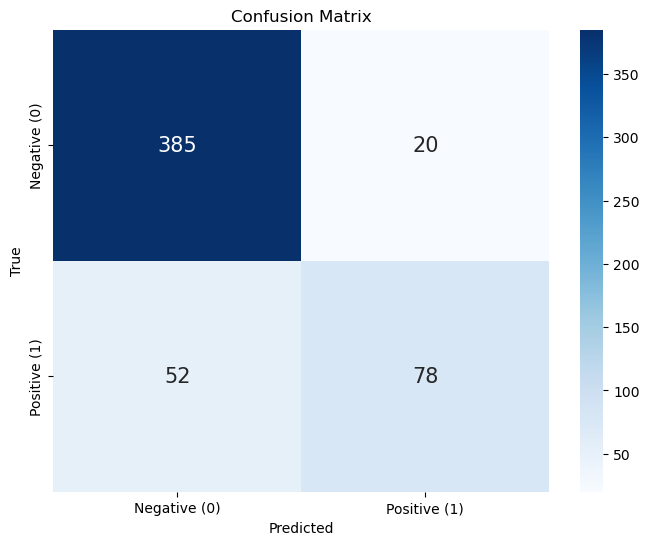

In [166]:
y_pred = clf2.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Definicja etykiet klas
class_labels = ['Negative (0)', 'Positive (1)']

# Wyświetlenie macierzy pomyłek z opisami
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, annot_kws={"fontsize":15})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

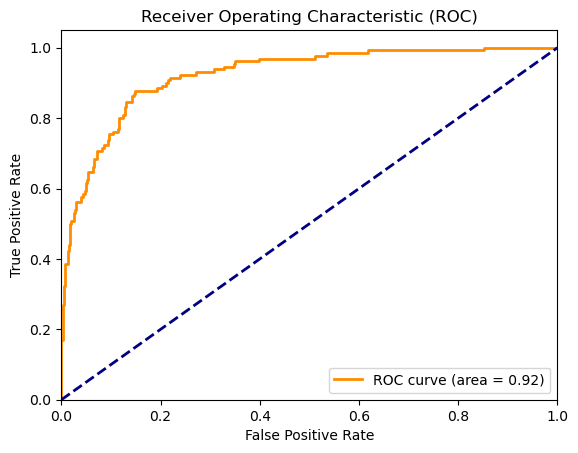

In [162]:
from sklearn.metrics import roc_curve, auc

y_pred_prob = clf2.predict_proba(X_test)[:,1]


fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

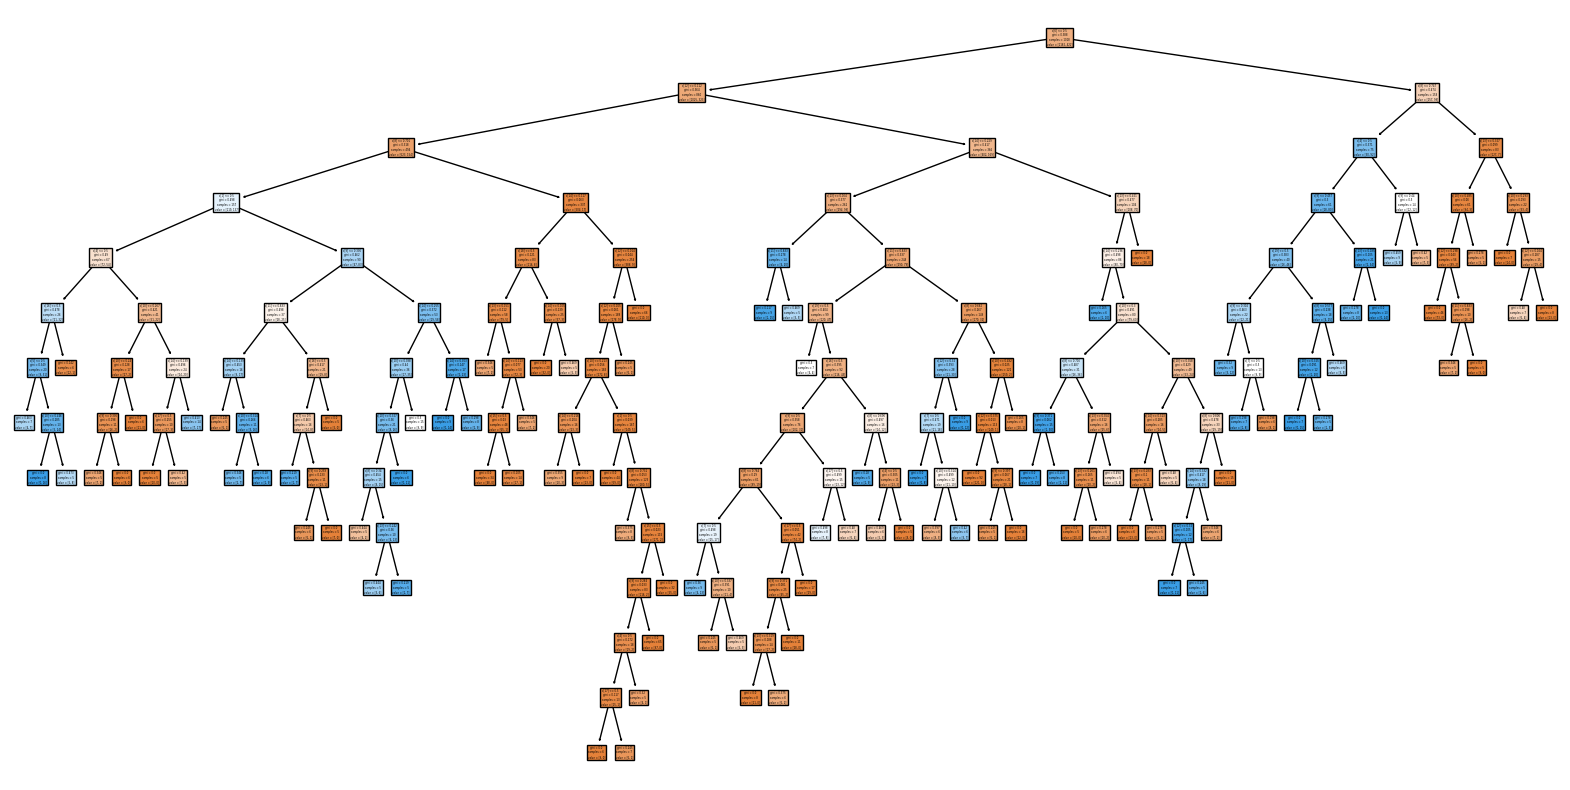

In [163]:
from sklearn.tree import plot_tree

# Wybierz jedno drzewo z lasu
tree = clf2.estimators_[0]

# Wizualizacja drzewa
plt.figure(figsize=(20,10))
plot_tree(tree, filled=True)
plt.show()

In [164]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
# Definicja modeli w słowniku
models = {
    'clf1': {'model': clf1},
    'clf2': {'model': clf2}
}

results = []

for name, info in models.items():
    model = info['model']
    model.fit(X_train, y_train)  # Dopasowanie modelu
    y_pred = model.predict(X_test)  # Predykcja etykiet
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # Predykcja prawdopodobieństw dla klasy pozytywnej
    auc = roc_auc_score(y_test, y_pred_prob)
    gini = 2 * auc - 1
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)  # Obliczenie F1-score dla domyślnej klasy (czyli dla klasy pozytywnej)
    error_rate = 1 - accuracy
    results.append({
        'Model': name,
        # 'Max Depth': info['max_depth'],
        'AUC': auc,
        'Gini': gini,
        'Accuracy': accuracy,
        'F1-score': f1,
        'Error Rate': error_rate
    })

# Tworzenie DataFrame z wynikami
df = pd.DataFrame(results)

In [165]:
df.head()

,Model,AUC,Gini,Accuracy,F1-score,Error Rate
0,clf1,0.925280,0.850560,0.865421,0.689655,0.134579
1,clf2,0.922906,0.845812,0.865421,0.684211,0.134579
